# Linear Regression as a Statistic Model For Automobile Price Prediction

# Overview

This dataset has been previously cleaned and properly processed in a project of the same subject. The purpose of the current notebook is to describe a the linear regression statistical model to predict the price of a car depending on the values of its attributes.

The structure that the project will have is the following:

1) Data visualization
2) Data selection
3) Linear regression development
4) Model training
5) Results

# Data Visualization

It is important to clearly understand the data we're working with since the selection of the data plays a crucial part in the efficiency and accuracy of the model. When we choose the right attributes to be considered when implementing linear regression, the results will display less noise and less error values.

For us to be able to understand the data, we can display multiple types of graphical aids in order to determine the attributes that could fit the model best.

This visualization can be implemented using the following libraries:

In [59]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

Since we're gonna need data for our project to work, we'll import the previously cleaned dataset:

In [60]:
# Import dataset
FILE_PATH = "real_estate_original.csv"
df = pd.read_csv(FILE_PATH).drop('No', axis=1)
df.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


To determine the correlation of each attribute against the result, we'll use a heatmap as follows:

<AxesSubplot:>

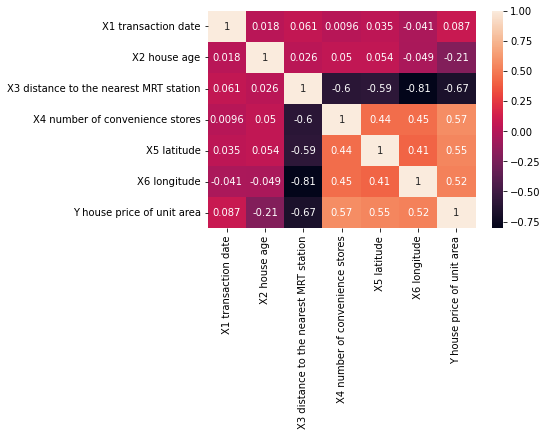

In [61]:
sb.heatmap(df.corr(), annot=True)

# Data Selection

It is evident that the **X1 transaction date** is not as relevant as other columns in terms of correlation, therefore, it will be dropped from the dataframe. Also, the **X3 distance to the nearest MRT station** column has a big correlation value against the result, but there are way more attributes that are positively correlated to the **price of unit area**, which means that, since the **distance to the nearest MRT station** attribute is negatively correlated, it would cause the predictions to have a very low variance, so it will be deleted too.

In [62]:
df.drop(['X1 transaction date', 'X3 distance to the nearest MRT station'], axis=1, inplace=True)

In order to determine which attributes could play a bigger role in the regression results, we need to test the **variance Inflation Factor**, which will be done by using the **statsmodels** library. This determines how much variance each column would cause with the current structure of the dataframe:

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(x):
    vif = pd.DataFrame()
    vif['input_vars'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif.iloc[:4, :]
    return vif


calculate_vif(df)

,input_vars,VIF
0,X2 house age,3.856563e+00
1,X4 number of convenience stores,4.609822e+00
2,X5 latitude,6.221970e+06
3,X6 longitude,6.213089e+06


We can see that both the latitude and the longitude have a very high **Variance Inflation Factor**, which probably means that both columns have the same impact over the price of the unit area, so we are going to remove from the dataframe the attribute that causes the least variance when taken out of the set:

In [64]:
# If we remove latitude
df_no_latitude = df.drop(['X5 latitude'], axis=1)
calculate_vif(df_no_latitude)

,input_vars,VIF
0,X2 house age,3.749916
1,X4 number of convenience stores,4.561482
2,X6 longitude,14.162884
3,Y house price of unit area,14.288697


In [65]:
# If we remove longitude
df_no_longitude = df.drop(['X6 longitude'], axis=1)
calculate_vif(df_no_longitude)

,input_vars,VIF
0,X2 house age,3.751080
1,X4 number of convenience stores,4.561207
2,X5 latitude,14.183128
3,Y house price of unit area,14.301539


We can see that by removing the latitude, the VIF values are smaller in general.

In [66]:
# Remove latitude from original df
df.drop('X5 latitude', axis=1, inplace=True)
df.head()

,X2 house age,X4 number of convenience stores,X6 longitude,Y house price of unit area
0,32.0,10,121.54024,37.9
1,19.5,9,121.53951,42.2
2,13.3,5,121.54391,47.3
3,13.3,5,121.54391,54.8
4,5.0,5,121.54245,43.1


# Linear Regression Development

In order to be able to operate with the data for the model to have the capacity of predicting data, we need to pass the dataframe to a numpy array and also separate the dataframe into its respective x and y columns beforehand.

In [67]:
# Separate data into training and testing data
df_train = df.sample(frac=0.8, random_state=25)
df_test = df.drop(df_train.index)

# Get x and y data
df_x = df_train.drop('Y house price of unit area', axis=1)
df_y = df_train.drop(df_x.columns, axis=1)

In [68]:
# Convert dataframes into numpy arrays
x_data = df_x.to_numpy()
y_data = df_y.to_numpy()
y_data = np.reshape(y_data, (y_data.shape[0],))

Now, we declare a function to get the result of a linear regression attempt with the current weights by following the $y_{pred}=\widehat{w}\cdot\widehat{x}+b$ formula, where $\widehat{w}$ is the vector of weights for each column, $\widehat{x}$ is the array of x values and $b$ is the scalar value of the bias.

In [69]:
def regression(x, w, b):
    return x.dot(w) + b

Then, we declare a loss array which will contain the squared error for each **y prediction**:

In [70]:
loss = np.zeros((x_data.shape[0]))

Now, we want to find a set of weights which give us the least amount of squared error, which can be done by using a gradient descent, where we compare the predictions with the actual values in order to know if any further improvement can be made or if we have encounter a local minima.

For this matter a **learning rate** ($\alpha$) is important to determine how big of a step the weights should take in the opposite direction of each column's **slope** on each epoch, which is also a parameter we'll tweak since we don't want to exceed the number of necessary epochs for the model to fit the data and we don't want to underestimate said quantity either.

For the definition of the **gradient descent** function it is important to stand out the cost formula, which is the following:

$$C= \frac{1}{n} * \sum{(y - y_{pred})}^2$$

Also, some helper functions will be added:

To get the loss for each epoch:

In [71]:
def get_loss(y, preds):
    return (1 / y.shape[0]) * np.sum(np.power(y - preds, 2))

In [72]:
def gradient_descent(x, y, w, b, epochs, learning_rate):
    # Get predictions with current weights
    preds = regression(x, w, b)
    # Get square error of predictions against the actual y values
    curr_loss = 0
    # Run all epochs
    for i in range(epochs):
        # Update predictions with current weights
        preds = regression(x, w, b)
        # Update current loss
        loss = get_loss(y, preds)
        # Check that current loss and previous loss aren't the same (since it means a local minima has been found)
        if np.array_equal(curr_loss, loss):
            print(f"Found local minima at epoch {i}")
            break
        else:
            # Update last loss
            curr_loss = loss
            # Get partial derivatives for weights and bias (negate the sign since we want to go against the slopes)
            dw = -(2 / x.shape[0]) * (x.T).dot(y - preds)
            db = -(2 / x.shape[0]) * np.sum(y - preds)
            # Adjust weights and bias according to the derivatives previously calculated
            w -= learning_rate * dw
            b -= learning_rate * db
    return w, b

# Model Training

To train the model, we'll use the **x** and **y** arrays we created before, since they come directly from the **df_train** variable, which was created with the purpose of splitting the data into training and testing sets.

In [73]:
# Initialize weight and bias again
w, b = np.random.rand((x_data.shape[1])) * 10, np.random.random()
# Perform gradient descent by using the x_data
EPOCHS, ALPHA = 1000, 0.00005
new_w, new_b = gradient_descent(x_data, y_data, w, b, EPOCHS, ALPHA)

# Results

Since we want to test our model with values it hasn't been trained with yet, we'll create an array with the x values of the **test** dataframe:

In [74]:
test_x = df_test.drop('Y house price of unit area', axis=1)
test_y = df_test.drop(test_x.columns, axis=1)

test_x = test_x.to_numpy()
test_y = test_y.to_numpy()

In order to get the results, we'll create two dataframes to better visualize the data:

In [75]:
# Get prediction
pred = regression(test_x, new_w, new_b)
# Make dataframes
pred_df = pd.DataFrame(pred)
actual_df = pd.DataFrame(test_y)

If we join both dataframes, we'd get the following table:

In [76]:
results = pd.concat([pred_df, actual_df], axis=1)
results.columns = ['Predicted Values', 'Actual Values']
results

,Predicted Values,Actual Values
0,41.314579,47.3
1,38.527494,34.3
2,29.707204,24.6
3,32.509402,22.9
4,41.273134,53.9
...,...,...
78,36.445788,35.3
79,38.553610,32.2
80,32.509883,23.0
81,49.912366,40.5


To see how good the performance of our model was, we can simply get the **Mean Absolute Error** and the **R Squared** corretlation by doing the following:

In [103]:
# Mean Absolute Error
def mean_abs_error(data_1, data_2):
    return np.sum(np.abs(data_1 - data_2)) / data_1.shape[0]

# R Squared
def r_squared(data_1, data_2):
    sst = np.sum((data_1 - np.mean(data_1)) ** 2)
    print(sst)
    ssr = np.sum((data_1 - data_2))
    print (ssr)
    return (sst - ssr) / sst

The Mean Absolute Error of the model is:

In [101]:
mean_abs_error(test_y, pred)

1076.483612581423

The $R^2$ score of the model is:

In [104]:
r_squared(test_y, pred)

18371.26674698795
12618.947909638537


0.3131149809412315